# Data Augmentation for brain tumor segmentation

## Qimin Zhang and Weiwei Qi

## 1. Config

In [14]:
import copy
import enum
import random
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path

import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
from torchvision.utils import make_grid, save_image

import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM

import numpy as np
import nibabel as nib
from unet import UNet
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

print('TorchIO version:', torchio.__version__)

torch.manual_seed(4460)
np.random.seed(4460)

TorchIO version: 0.13.24


In [7]:
# Some visualization functions

def show_nifti(image_path_or_image, colormap='gray'):
    try:
        from niwidgets import NiftiWidget
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            widget = NiftiWidget(image_path_or_image)
            widget.nifti_plotter(colormap=colormap)
    except Exception:
        if isinstance(image_path_or_image, nib.AnalyzeImage):
            nii = image_path_or_image
        else:
            image_path = image_path_or_image
            nii = nib.load(str(image_path))
        k = int(nii.shape[-1] / 2)
        plt.imshow(nii.dataobj[..., k], cmap=colormap)

def show_sample(sample, image_name, label_name=None):
    if label_name is not None:
        sample = copy.deepcopy(sample)
        affine = sample[label_name][AFFINE]
        label = sample[label_name][DATA][0].numpy().astype(np.uint8)
        label_image = torchio.utils.nib_to_sitk(label, affine)
        border = sitk.BinaryContour(label_image)
        border_array, _ = torchio.utils.sitk_to_nib(border)
        border_tensor = torch.from_numpy(border_array)
        image_tensor = sample[image_name][DATA][0]
        image_tensor[border_tensor > 0.5] = image_tensor.max()
    with tempfile.NamedTemporaryFile(suffix='.nii') as f:
        torchio.ImagesDataset.save_sample(sample, {image_name: f.name})
        show_nifti(f.name)

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

## 2. Convert Nifti to Numpy

In [2]:
dataPath = './data'


t1_path = os.path.join(dataPath, 'all_gbm_pre_reg')
t1_contrast_path = os.path.join(dataPath, 'all_gbm_post_reg')
tumor_path = os.path.join(dataPath, 'all_tumors_reg')
brain_mask_path = os.path.join(dataPath, 'brain_masks')


t1_path = os.path.join(dataPath, 'all_gbm_pre_reg')
t1_contrast_path = os.path.join(dataPath, 'all_gbm_post_reg')
tumor_path = os.path.join(dataPath, 'all_tumors_reg')
brain_mask_path = os.path.join(dataPath, 'brain_masks')


imgPaths = os.listdir(t1_path)
t1_locations = []
for path in imgPaths:
    if path.endswith('.nii.gz'):
        t1_locations.append(path)

imgPaths = os.listdir(t1_contrast_path)
t1_contrast_locations = []
for path in imgPaths:
    if path.endswith('.nii.gz'):
        t1_contrast_locations.append(path)

imgPaths = os.listdir(tumor_path)
tumor_locations = []
for path in imgPaths:
    if path.endswith('.nii.gz'):
        tumor_locations.append(path)
        
imgPaths = os.listdir(brain_mask_path)
brain_mask_locations = []
for path in imgPaths:
    if path.endswith('.nii.gz'):
        brain_mask_locations.append(path)
        
newPath = os.path.join(dataPath, 'numpyData')
if not os.path.exists(newPath):
    os.mkdir(newPath)
        
num_t1_path = os.path.join(newPath, 'num_t1')
if os.path.exists(num_t1_path):
    print('Folder already exists, so I did not create any numpy from t1.')
else:
    os.mkdir(num_t1_path)

    print('I am starting to convert t1 images.')
    path = t1_path
    t1_progress = tqdm.tqdm(enumerate(t1_locations))
    for i, imageLocation in t1_progress:
        t1_progress.set_description(f"Processing image {imageLocation}")
        # get the .nii image
        imageData = nib.load(os.path.join(path,imageLocation))
        # convert to numpy
        numpyImage = imageData.get_data()
        np.save(os.path.join(num_t1_path, imageLocation), numpyImage)
        
        
num_t1_contrast_path = os.path.join(newPath, 'num_t1_contrast')
if os.path.exists(num_t1_contrast_path):
    print('Folder already exists, so I did not create any numpy from t1 contrast.')
else:
    os.mkdir(num_t1_contrast_path)

    print('I am starting to convert t1 contrast images.')
    path = t1_contrast_path
    t1_contrast_progress = tqdm.tqdm(enumerate(t1_contrast_locations))
    for i, imageLocation in t1_contrast_progress:
        t1_contrast_progress.set_description(f"Processing image {imageLocation}")
        # get the .nii image
        imageData = nib.load(os.path.join(path,imageLocation))
        # convert to numpy
        numpyImage = imageData.get_data()
        np.save(os.path.join(num_t1_contrast_path, imageLocation), numpyImage)
        
num_tumor_path = os.path.join(newPath, 'num_tumor')
if os.path.exists(num_tumor_path):
    print('Folder already exists, so I did not create any numpy from tumors.')
else:
    os.mkdir(num_tumor_path)

    print('I am starting to convert tumor images.')
    path = tumor_path
    tumor_progress = tqdm.tqdm(enumerate(tumor_locations))
    for i, imageLocation in tumor_progress:
        tumor_progress.set_description(f"Processing image {imageLocation}")
        # get the .nii image
        imageData = nib.load(os.path.join(path,imageLocation))
        # convert to numpy
        numpyImage = imageData.get_data()
        np.save(os.path.join(num_tumor_path, imageLocation), numpyImage)
        
num_brain_mask_path = os.path.join(newPath, 'num_brain_mask')
if os.path.exists(num_brain_mask_path):
    print('Folder already exists, so I did not create any numpy from brain masks.')
else:
    os.mkdir(num_brain_mask_path)

    print('I am starting to convert brain mask images.')
    path = brain_mask_path
    brain_mask_progress = tqdm.tqdm(enumerate(brain_mask_locations))
    for i, imageLocation in brain_mask_progress:
        brain_mask_progress.set_description(f"Processing image {imageLocation}")
        # get the .nii image
        imageData = nib.load(os.path.join(path,imageLocation))
        # convert to numpy
        numpyImage = imageData.get_data()
        np.save(os.path.join(num_brain_mask_path, imageLocation), numpyImage)

print('All conversion done.')

Folder already exists, so I did not create any numpy from t1.
Folder already exists, so I did not create any numpy from t1 contrast.
Folder already exists, so I did not create any numpy from tumors.
Folder already exists, so I did not create any numpy from brain masks.
All conversion done.


## 3. Traditional Data Augmentation with TorchIO

In [3]:
import torchio
from torchio.transforms import Rescale, RandomAffine
from torchvision.transforms import Compose
from torch.utils.data import DataLoader

If you use TorchIO for your research, please cite the following paper:

Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning
(https://arxiv.org/abs/2003.04696)


In [4]:
dataPath = Path('./data')

t1_path = dataPath / 'all_gbm_pre_reg'
tumor_path = dataPath / 'all_tumors_reg'
brain_mask_path = dataPath / 'brain_masks'

t1_locations = sorted(t1_path.glob('*.nii.gz'))
tumor_locations = sorted(tumor_path.glob('*.nii.gz'))
brain_mask_locations = sorted(brain_mask_path.glob('*.nii.gz'))


assert len(t1_locations) == len(tumor_locations) == len(brain_mask_locations)

subjects = []
for (image_path, label_path, brain_mask_path) in zip(t1_locations, tumor_locations, brain_mask_locations):
    subject = torchio.Subject(
        torchio.Image('t1', image_path, torchio.INTENSITY),
        torchio.Image('tumor', label_path, torchio.LABEL),
        torchio.Image('brain mask', brain_mask_path, torchio.LABEL)
    )
    subjects.append(subject)
    
dataset = torchio.ImagesDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 335 subjects


### 3.1 Exploration

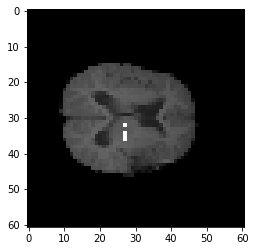

In [15]:
sample = dataset[0]

to_ras = torchio.transforms.ToCanonical()
to_iso = torchio.transforms.Resample((4, 4, 4))
ras_iso_transform = Compose([to_ras, to_iso])
ras_iso_sample = ras_iso_transform(sample)
show_sample(ras_iso_sample, 't1', label_name='tumor')

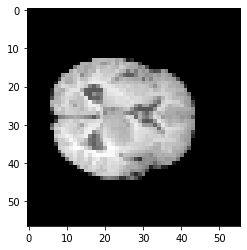

In [16]:
crop_transform = torchio.transforms.Crop(cropping=(2, 2, 3, 2, 0, 4))
transformed = crop_transform(ras_iso_sample)
show_sample(transformed, 't1')

In [17]:
ras_iso_crop_transform = Compose([ras_iso_transform, crop_transform])
nicer_dataset = torchio.ImagesDataset(subjects, transform=ras_iso_crop_transform)

### 3.2 Augmentation

#### 3.2.1 Intensity augmentation

In [20]:
# Noise

noise_transform = torchio.transforms.RandomNoise(std_range=(0.5, 0.5), seed=seed)
znormed = ras_iso_transform(znormed)
show_sample(znormed, MRI)
transformed = noise_transform(znormed)
show_sample(transformed, MRI)

NameError: name 'seed' is not defined